In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import csv
import time
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn import datasets, neighbors, linear_model, preprocessing
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import MiniBatchKMeans, KMeans

In [24]:
data = pd.read_csv("train.csv")
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
data["target"].mean()

# Classification

- Data normalization
- data split into train and cv set

Code for gini (evaluation per the problem description). 
- For the best accuracy, we want a normalized gini score to be as close as possible to 1. 
- The gini score for a random classifier is 0. 
- Also, if we get a negative gini score, we can just reverse the outcome to get a positive gini score of the same magnitude. 
- Gini score is a good metric for a skewed dataset such as this one. 
- For the evaluation, it needs the 'probability' from the classifier, not just the prediction (0 or 1)! 

In [3]:
#helper functions
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

#results is a list of dictionaries
def evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename):
    estimator_name = str(estimator).split("(")[0]
    fit = estimator.fit(X_train, y_train)
    accuracy = fit.score(X_cv, y_cv)
    gini_cv = gini_normalized(y_cv, estimator.predict_proba(X_cv)[:,1])
    gini_train = gini_normalized(y_train, estimator.predict_proba(X_train)[:,1])
    precision, recall, fscore, support = precision_recall_fscore_support(pd.Series(y_cv).values, estimator.predict(X_cv), pos_label=1, average='binary')
    #print(precision)
    filename = filename + '.pkl'
    joblib.dump(estimator, filename)
    results_list = [estimator_name, filename, accuracy, gini_cv, gini_train, precision, recall, fscore]
    return results_list

Let's normalize the data using scikitlearn preprocessing. Each column will have a mean of 0 and variance of 1. 
The output of normalizing is a numpy array, so we convert it back into a pandas dataframe. Note that we will not be normalizing 'y' values. 


In [30]:
scaler = StandardScaler()
X_np = scaler.fit_transform(data.drop("target", axis=1))
print(X_np.shape)
normalized_data = pd.DataFrame(data=X_np, columns=data.drop("target", axis=1).columns)
normalized_data = pd.concat([normalized_data, data["target"]], axis=1)
normalized_data.describe()
train,cv=train_test_split(normalized_data,test_size = 0.1, random_state=0,stratify=normalized_data['target'])
train.describe()
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_cv = cv.drop("target", axis = 1)
y_cv = cv["target"]

(595212L, 58L)


1. Vanilla logistic regression has a gini score of 0.2066 - much better than a random classifier.
2. The first strategy to deal with imbalanced dataset is using class_weight = "balanced" in the classifier. This will automatically give more weight to the few positives in the data. This results in a gini score of 0.22 - much better than a random classifier!

In [ ]:
#trial run
estimator = LogisticRegression(C=1, class_weight = "balanced")
#estimator = LogisticRegression(C=1)
fit = estimator.fit(X_train, y_train)
score = fit.score(X_cv, y_cv)
print(score)
print(classification_report(y_cv, estimator.predict(X_cv)))
gini_cv = gini_normalized(y_cv, estimator.predict_proba(X_cv)[:,1])
gini_train = gini_normalized(y_train, estimator.predict_proba(X_train)[:,1])
print([gini_train, gini_cv])

In [ ]:
cols = ['estimator_name', 'filename', 'accuracy', 'gini_cv', 'gini_train', 'precision', 'recall', 'fscore']
results_file = open('resultsfile.csv','a+')
line = ",".join(cols)
results_file.write(line + '\n')
results_file.close()
results = pd.DataFrame([], columns = cols)

In [ ]:
estimators = [LogisticRegression(C = 1, class_weight = "balanced"), svm.LinearSVC(class_weight = "balanced", verbose = 2), DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 5, class_weight = "balanced"), RandomForestClassifier(max_depth=2, random_state=0, class_weight = "balanced", verbose = 2), KNeighborsClassifier(n_neighbors=3)]
filenames = ['logistic_C1', 'SVC_C1_linear', 'DecTree_3','DecTree_5','RandForest', 'KNeigh_3']

#for i in range(2,len(estimators)):
for i in [0,2,3,4]:
    estimator = estimators[i]
    filename = filenames[i]
    results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
    print(results_list)
    df = pd.DataFrame([results_list], columns = cols)
    results = pd.concat([results, df],ignore_index=True)
    line = str(results_list)[1:-1]
    results_file = open('resultsfile.csv','a')
    results_file.write(line + '\n')
    results_file.close()
    
print(results)

In [ ]:
i=1
estimator = estimators[i]
filename = filenames[i]
results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
print(results_list)
df = pd.DataFrame([results_list], columns = cols)
results = pd.concat([results, df],ignore_index=True)

In [ ]:
clf = joblib.load(results['filename'].iloc[0])

In [ ]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=1000,
                      n_init=10, max_no_improvement=10, verbose=2)
t0 = time.time()
mbk.fit(X_train)
t_mini_batch = time.time() - t0

# Feature reduction

In [ ]:
data = pd.read_csv("train.csv")
cols_trimmed = [x for x in data.columns if 'calc' not in x]
data_1 = data[cols_trimmed]
scaler = StandardScaler()
X_np = scaler.fit_transform(data_1.drop("target", axis=1))
print(X_np.shape)
norm_X_data_1 = pd.DataFrame(data=X_np, columns=data_1.drop("target", axis=1).columns)
#normalized_data = pd.concat([normalized_data, data["target"]], axis=1)
norm_X_data_1.describe()

# Visualization

In [ ]:
pca = PCA(n_components=30, svd_solver='full', random_state=1001)
X = pca.fit_transform(normalized_data.drop(['id', 'target'], axis = 1))
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_[:2].sum())

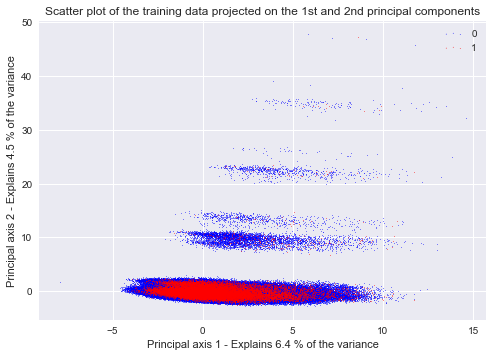

In [54]:
y = data['target'].values.astype(np.int8)
colors = ['b', 'r']
target_names = np.unique(y)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-data.png', dpi=150)
plt.show()

In [46]:
pca = PCA(n_components=20, svd_solver='full', random_state=1001)
X = pca.fit_transform(norm_X_data_1.drop(['id'], axis = 1))
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_[:2].sum())

0.789808839812
0.167850913212


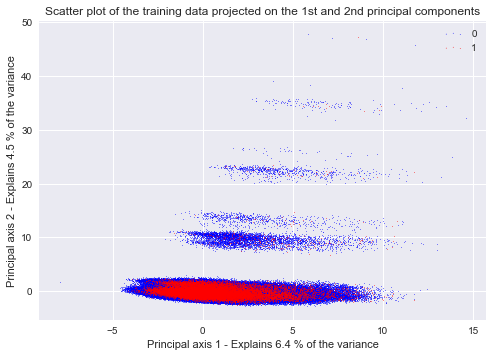

In [55]:
y = data_1['target'].values.astype(np.int8)
colors = ['b', 'r']
target_names = np.unique(y)
for color, i, target_name in zip(colors, [0, 1], target_names):
#for color, i, target_name in zip([colors[0]], [0], [target_names[0]]):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

#plt.savefig('pca-porto-03.png', dpi=150)
plt.show()

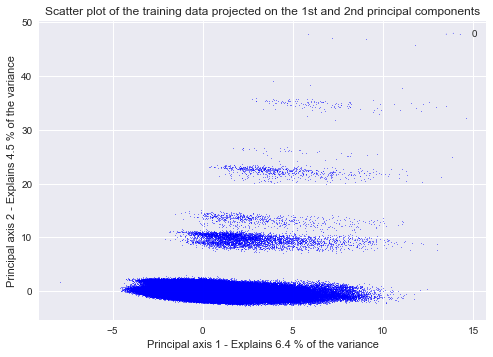

In [56]:
y = data_1['target'].values.astype(np.int8)
colors = ['b', 'r']
target_names = np.unique(y)
#for color, i, target_name in zip(colors, [0, 1], target_names):
for color, i, target_name in zip([colors[0]], [0], [target_names[0]]):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

#plt.savefig('pca-porto-03.png', dpi=150)
plt.show()

We tried to visualize the data by doing a PCA. Selecting 20 features on the original dataset after normalization explains ~50% of the variability. For the reduced and normalized dataset - data_1, we can explain 79% of the variability. In the visualization in 2D, we will only be able to see 16.7 % of the variability. 

Plotting the data in 2D shows that the points labeled 1 clearly lie in the red cluster. Bad news is, this cluster lies entirely on top of the blue cluster - there is no separation! Perhaps this is why we were not able to reach accuracies higher than ~50%. 


After removing the calc features, we are able to capture 34% of the variability by choosing 5 principal components, but this is still not high enough to give a faithful representation of our data in 2D. 

We tried to visualize with t-SNE which can discover more complex features, but the code was aborted because too slow. 

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, random_state=0)
tsne.fit_transform(X)

# Imbalanced Learn

With the current dataset, linearSVM and kneighbors are both too slow - could not get them to run at all on my machine. Let us simplify the dataset.
1. Features - remove all features that have calc in the name - as we had seen earlier using our heatmaps, these features have 0 correlation with the target.
2. balancing the data. We will choose all of the row that have target = 1 and choose that number of rows with target = 0. So we will go from an imbalance of 1:32 to 1:1. Our data will also be a lot smaller, so should be much easier to train.

In [8]:
from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(ratio='majority', return_indices=False, random_state=None, replacement=False)
X_resampled, y_resampled = rus.fit_sample(data_1.drop('target', axis = 1), data_1['target'])
print(sorted(Counter(y_resampled).items()))

[(0, 21694), (1, 21694)]


In [9]:
scaler = StandardScaler()
X_np = scaler.fit_transform(X_resampled)
norm_X_resampled = pd.DataFrame(data=X_np, columns=data_1.drop("target", axis=1).columns)
norm_Y_resampled = pd.DataFrame(data=y_resampled, columns = ['target'])
norm_data_resampled = pd.concat([norm_X_resampled, norm_Y_resampled], axis=1)
norm_data_resampled.describe()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,target
count,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,...,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,4.338800e+04,43388.000000
mean,-3.699447e-16,9.170545e-15,3.403964e-15,-7.386786e-15,-1.583314e-15,-2.287581e-14,-2.098982e-14,-2.452268e-14,-2.210917e-15,3.629107e-15,...,-1.719607e-16,-1.110981e-14,2.284687e-15,1.283439e-15,1.331024e-15,1.065338e-12,-1.182065e-14,-2.112059e-14,7.314206e-13,0.500000
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,0.500006
min,-1.734985e+00,-9.920411e-01,-3.519707e+00,-1.631947e+00,-2.876992e+00,-1.002472e+00,-7.379002e-01,-6.451685e-01,-4.628107e-01,-4.639850e-01,...,-2.102890e+00,-2.410252e+00,-1.126917e+01,-1.853512e+00,-2.795588e+00,-4.021063e+00,-2.118839e+00,-3.492717e+00,-4.507458e+00,0.000000
25%,-8.652559e-01,-9.920411e-01,-5.418867e-01,-9.035971e-01,-8.624198e-01,-3.352647e-01,-7.379002e-01,-6.451685e-01,-4.628107e-01,-4.639850e-01,...,4.755361e-01,-1.380494e+00,8.188623e-02,-9.220708e-01,-4.089958e-01,-1.140004e+00,-6.394340e-01,1.580313e-01,-4.144809e-01,0.000000
50%,-1.442713e-03,-4.961177e-01,-5.418867e-01,-1.752469e-01,-8.624198e-01,-3.352647e-01,-7.379002e-01,-6.451685e-01,-4.628107e-01,-4.639850e-01,...,4.755361e-01,6.790211e-01,8.188623e-02,6.946329e-02,7.843005e-01,3.134095e-02,-2.213962e-01,2.623478e-01,2.919831e-01,0.500000
75%,8.601166e-01,4.957291e-01,9.470234e-01,5.531033e-01,1.152153e+00,-3.352647e-01,1.355197e+00,1.549983e+00,-4.628107e-01,-4.639850e-01,...,4.755361e-01,6.790211e-01,8.188623e-02,9.708580e-01,7.843005e-01,6.405891e-01,4.024029e-01,3.411108e-01,7.100846e-01,1.000000
max,1.731471e+00,2.479423e+00,3.924843e+00,2.373979e+00,1.152153e+00,3.667982e+00,1.355197e+00,1.549983e+00,2.160711e+00,2.155242e+00,...,4.755361e-01,2.738537e+00,1.143294e+01,1.241276e+00,7.843005e-01,1.449565e+01,1.171821e+01,9.835305e-01,9.070418e-01,1.000000


In [10]:
train,cv=train_test_split(norm_data_resampled,test_size = 0.3, random_state=0,stratify=norm_data_resampled['target'])
X_train = train.drop("target", axis=1)
y_train = train["target"]
X_cv = cv.drop("target", axis = 1)
y_cv = cv["target"]

In [12]:
cols = ['estimator_name', 'filename', 'accuracy', 'gini_cv', 'gini_train', 'precision', 'recall', 'fscore']
results_file = open('resultsfile2.csv','a+')
line = ",".join(cols)
results_file.write(line + '\n')
results_file.close()
results = pd.DataFrame([], columns = cols)

In [14]:
from sklearn.calibration import CalibratedClassifierCV
estimators = [CalibratedClassifierCV(svm.LinearSVC(class_weight = "balanced", verbose = 2)), DecisionTreeClassifier(max_depth = 7, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 9, class_weight = "balanced"),KNeighborsClassifier(n_neighbors=5)]
filenames = ['SVC_C1_linear_1', 'DecTree_7_1','DecTree_9_1','KNeigh_5_1']
estimators = [GaussianNB()]
filenames = ['GaussianNB_1']
estimators = [LogisticRegression(C = 1, class_weight = "balanced"), CalibratedClassifierCV(svm.LinearSVC(class_weight = "balanced", verbose = 2)), DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"),DecisionTreeClassifier(max_depth = 5, class_weight = "balanced"), RandomForestClassifier(max_depth=2, random_state=0, class_weight = "balanced", verbose = 2), KNeighborsClassifier(n_neighbors=3)]
filenames = ['logistic_C1_1', 'SVC_C1_linear_1', 'DecTree_3_1','DecTree_5_1','RandForest_1', 'KNeigh_3_1']
#for i in range(0,len(estimators)):
#for i in [0,2,3,4,5]:
for i in range(0,1):
    estimator = estimators[i]
    filename = filenames[i]
    results_list =  evaluate_clf(estimator, X_train, y_train, X_cv, y_cv, filename)
    print(results_list)
    df = pd.DataFrame([results_list], columns = cols)
    results = pd.concat([results, df],ignore_index=True)
    line = str(results_list)[1:-1]
    results_file = open('resultsfile2.csv','a')
    results_file.write(line + '\n')
    results_file.close()
    
print(results)

['LogisticRegression', 'logistic_C1_1.pkl', 0.58262272412998384, 0.23103153564593024, 0.26061502065421577, 0.58906379453189728, 0.54625076828518748, 0.56685003587658467]
       estimator_name           filename  accuracy   gini_cv  gini_train  \
0          GaussianNB   GaussianNB_1.pkl  0.570177  0.230329    0.245074   
1  LogisticRegression  logistic_C1_1.pkl  0.582623  0.231032    0.260615   

   precision    recall    fscore  
0   0.628050  0.344038  0.444555  
1   0.589064  0.546251  0.566850  


Let's try visualizations again on this reduced dataset. 

# Making predictions on test data

In [17]:
test = pd.read_csv('test.csv')
cols_trimmed = [x for x in test.columns if 'calc' not in x]
test_1 = test[cols_trimmed]
scaler = StandardScaler()
X_np = scaler.fit_transform(test_1)
norm_test = pd.DataFrame(data=X_np, columns=cols_trimmed)
clf = joblib.load('logistic_C1_1.pkl')
y = clf.predict_proba(norm_test)

In [21]:
df = pd.DataFrame.from_items([("target", y[:,1])])
test_results = pd.concat([test["id"], df], axis = 1)
test_results.to_csv("submission.csv", index = False)